In [1]:
import numpy as np
from numpy.linalg import inv,det

def r1Matr2(x2,y2,O,x1,y1):
    
    Oxx = O[0,0]
    Oxy = O[0,1]
    Oyx = O[1,0]
    Oyy = O[1,1]
    
    return ((x2*Oxx + y2*Oyx)*x1 + (x2*Oxy + y2*Oyy)*y1)

def gaussian(wlen,detsize,npix,ray):
    
    # wave vector
    k = 2*np.pi/wlen
    
    # detector
    x = np.linspace(-detsize/2,detsize/2,npix)
    up,vp = np.meshgrid(x,x)
    
    # decenter parameter
    uo = ray[0]
    vo = ray[1]
    
    # gaussian
    wo = 100*wlen
    zr = np.pi*wo**2/wlen
    Q = np.array([[1/(1j*zr),0],
                  [0,1/(1j*zr)]])
    
    up -= uo
    vp -= vo
    
    return np.exp(-1j*k/2*r1Matr2(up,vp,Q,up,vp))
    
    

def eval_gaussian(sys,wlen,detsize,npix,ray):
    
    # wave vector
    k = 2*np.pi/wlen
    
    # detector
    x = np.linspace(-detsize/2,detsize/2,npix)
    up,vp = np.meshgrid(x,x)
    up = np.ravel(up)
    vp = np.ravel(vp)
    
    r2 = np.array([up,
                   vp])
    
    # decenter parameter
    uo = ray[0]
    vo = ray[1]
    
    ro = np.array([uo,vo])
    
    # gaussian
    wo = 100*wlen
    zr = np.pi*wo**2/wlen
    Q = np.array([[1/(1j*zr),0],
                  [0,1/(1j*zr)]])
    
    # RTM
    A = sys[0:2,0:2]
    B = sys[0:2,2:4]
    C = sys[2:4,0:2]
    D = sys[2:4,2:4]
    lo = B[0,0]
    
    # prop ray - UNUSED
    rp = sys @ ray
#     up -= rp[0]
#     vp -= rp[1]
    
    # Propagate Gaussian
    Qp_n = (C + D @ Q)
    Qp_d = inv(A + B @ Q)
    Qp   = Qp_n @ Qp_d
    
    # Propagated Beamlet Phase matrices
    orig_matrx = inv(inv(Q) + inv(A) @ B)
    cros_matrx = inv(A @ inv(Q) + B)
    
    beam_phase = r1Matr2(up,vp,Qp,up,vp)
    dist_phase = r1Matr2(uo,vo, orig_matrx,uo,vo)
    cros_phase = r1Matr2(uo,vo,cros_matrx,up,vp)
    
#     beam_phase = Qp[0,0]*up**2 + (Qp[1,0] + Qp[0,1])*up*vp + Qp[1,1]*vp**2
#     dist_phase = orig_matrx[0,0]*uo**2 + (orig_matrx[1,0] + orig_matrx[0,1])*uo*vo + orig_matrx[1,1]*vo**2
#     cros_phase = -2*(cros_matrx[0,0]*uo*up + cros_matrx[1,0]*up*vo + cros_matrx[0,1]*uo*vp + cros_matrx[1,1]*vo*vp)
    
    phasor = beam_phase + dist_phase + cros_phase + 2*lo
    phase = np.exp(-1j*k*lo)
    phase *= np.exp(-1j*k/2 * beam_phase)
    phase *= np.exp(-1j*k/2 * dist_phase)
    phase *= np.exp(-1j*k/2 * cros_phase)
    beam = np.sqrt(det(A + B @ Q))*phase
    
    return beam    

In [8]:
efl = 10
dis = 10
wlen = 1e-6
npix = 512
detsize = 1e-3
nrays = 10
cut = 32
beamlist = np.zeros([npix,npix,nrays*nrays],dtype='complex128')
xlis = []
ylis = []

x = np.linspace(-.5,.5,nrays)
y = np.linspace(-.5,.5,nrays)

for ijk in range(nrays):
    for lmn in range(nrays):

        ray = np.array([x[ijk],
                        y[lmn],
                        0,
                        0])
        
        xlis.append(ray[0])
        ylis.append(ray[1])

        sys = np.array([[1-dis/efl + 1e-20,0,dis,0],
                        [0,1-dis/efl + 1e-20,0,dis],
                        [-0/efl,0,1,0],
                        [0,-0/efl,0,1]])
        
        beamlist[:,:,ijk] = gaussian(wlen,detsize,npix,ray)

In [9]:
ray = np.array([np.linspace(-1,1,5),
                np.linspace(-1,1,5)])

matm = np.eye(2) @ ray
raym = np.transpose(ray) @ matm 
raym.shape

(5, 5)

<ipython-input-4-b28326d0f9cc>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[10,5])


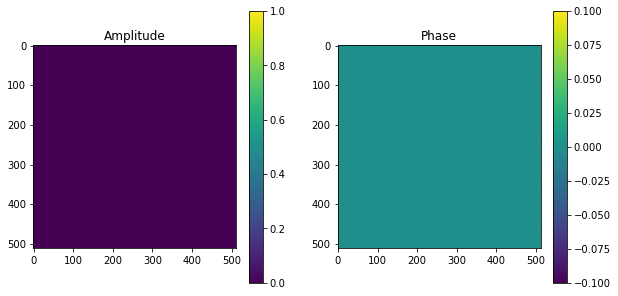

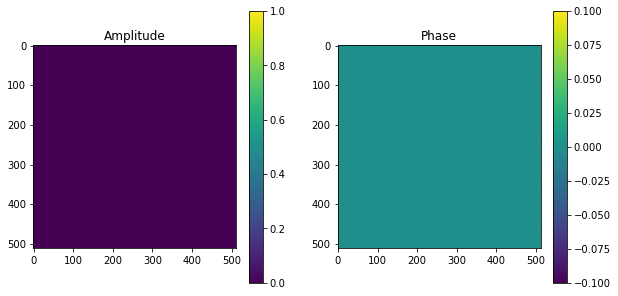

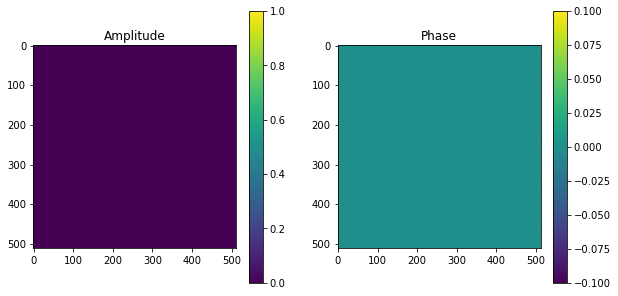

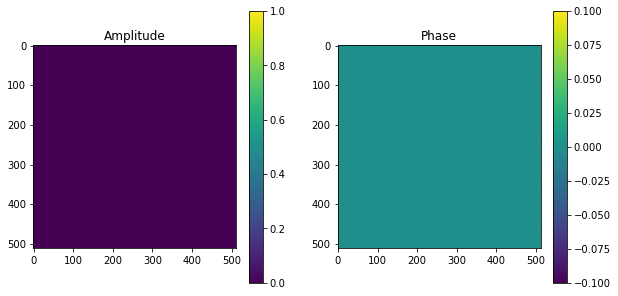

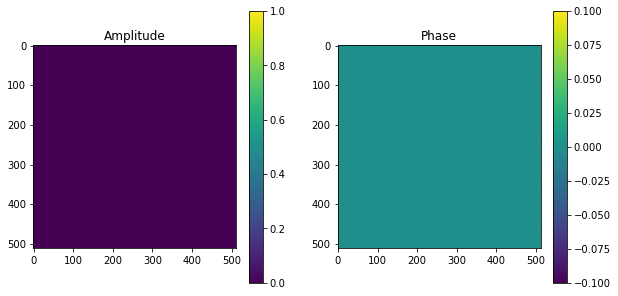

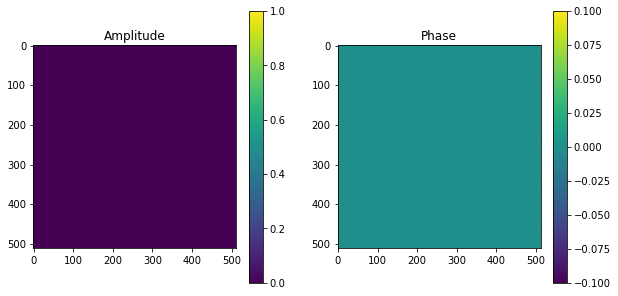

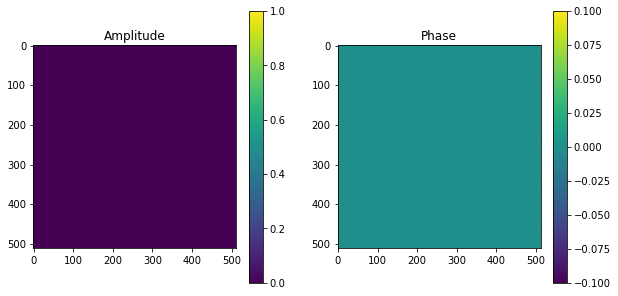

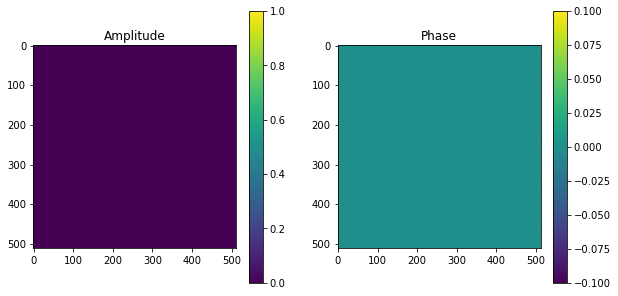

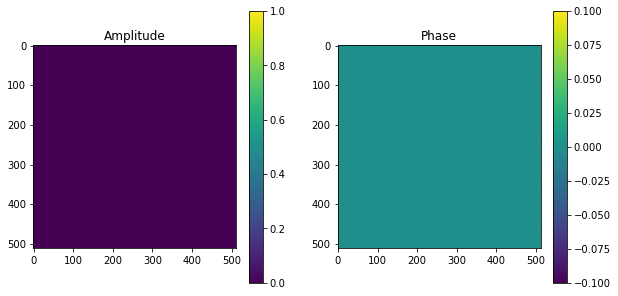

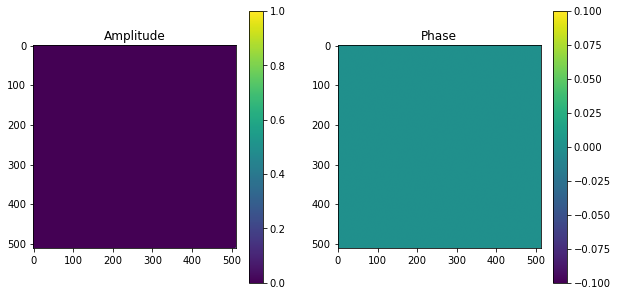

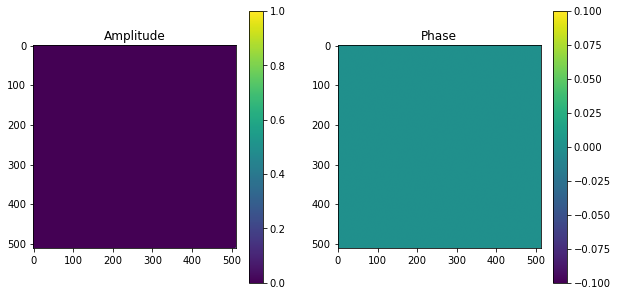

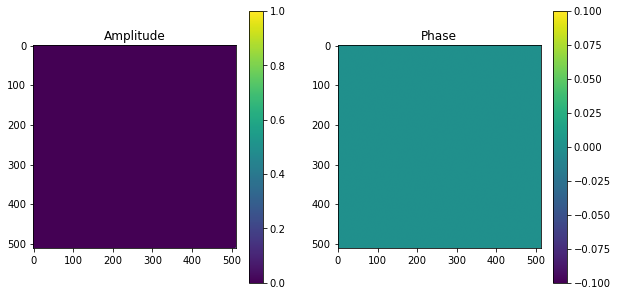

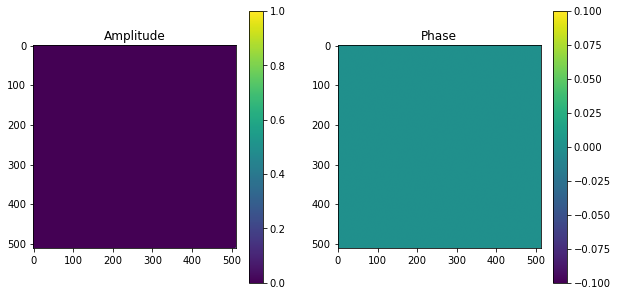

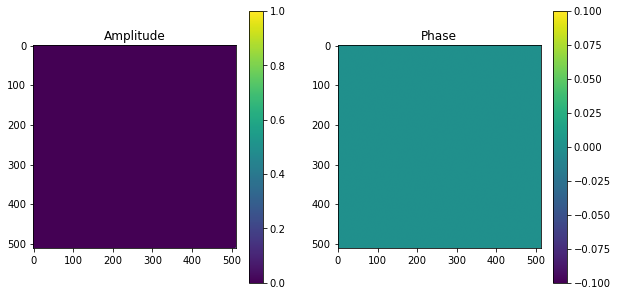

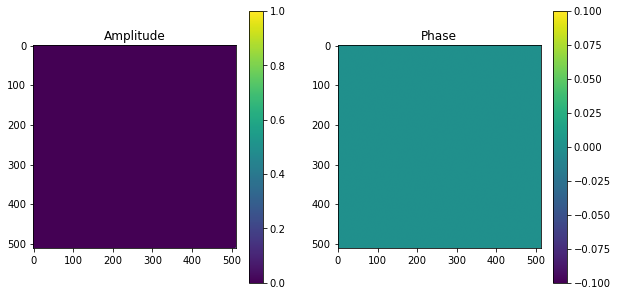

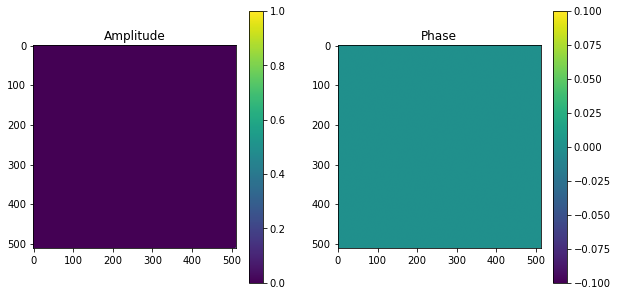

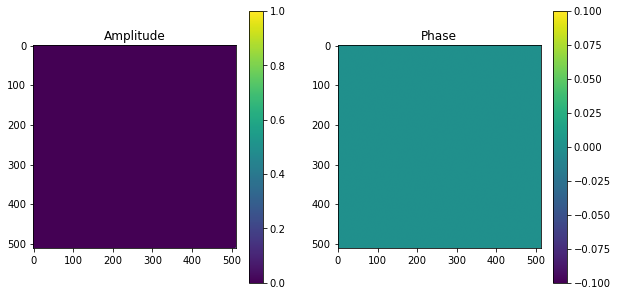

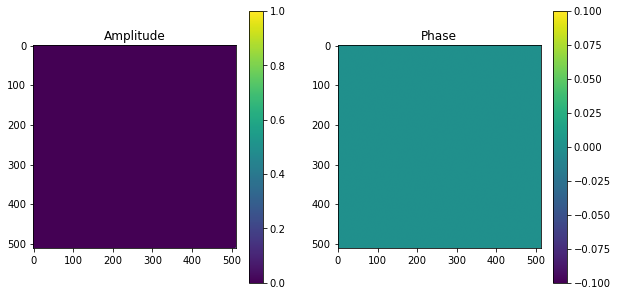

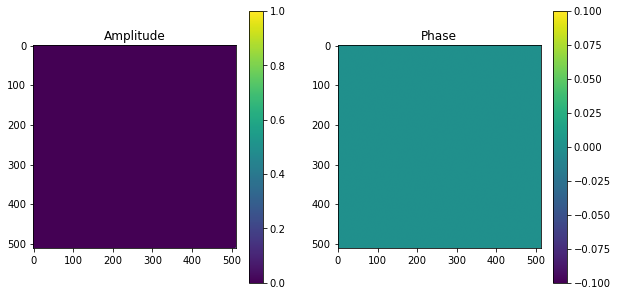

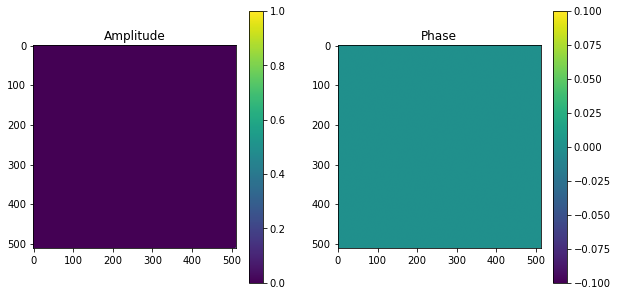

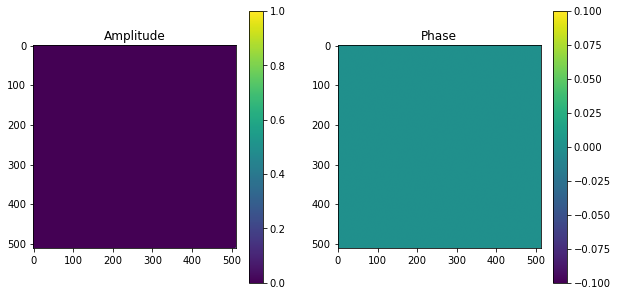

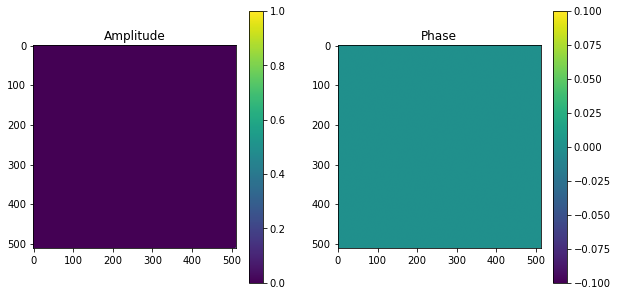

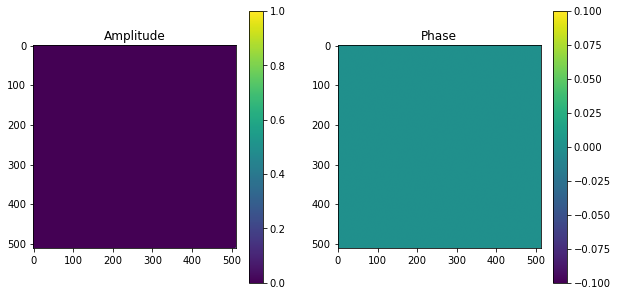

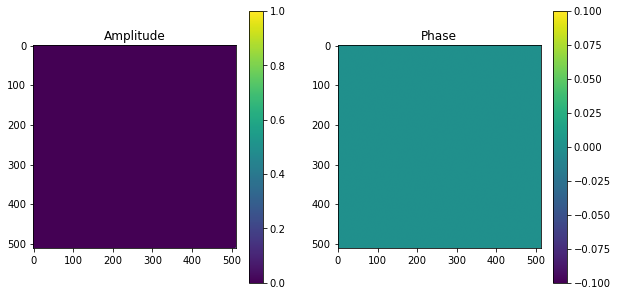

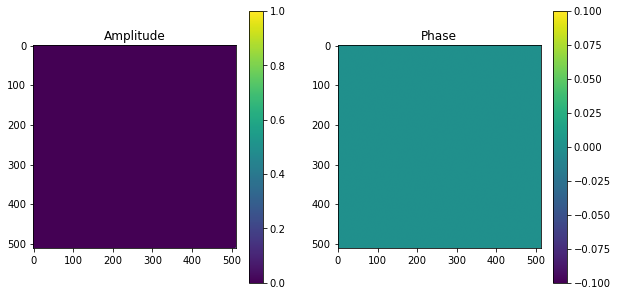

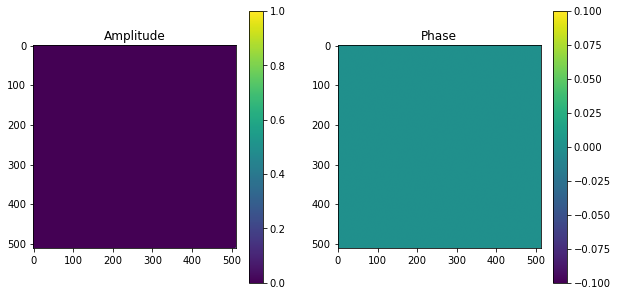

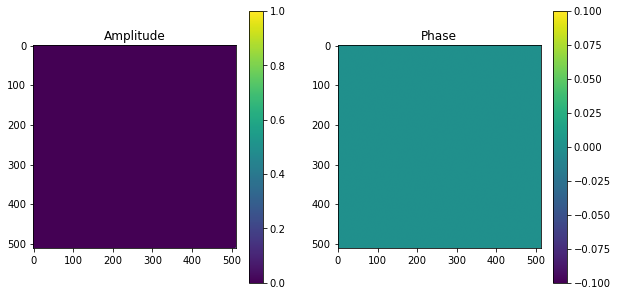

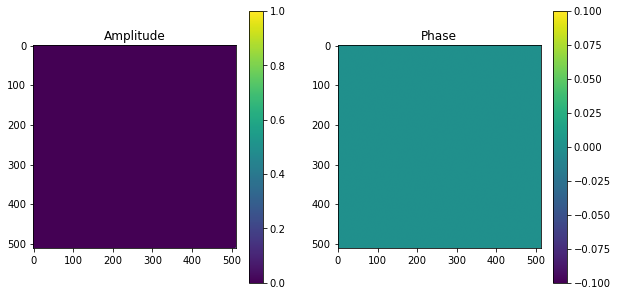

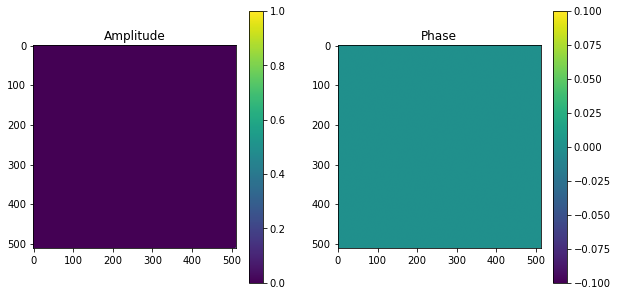

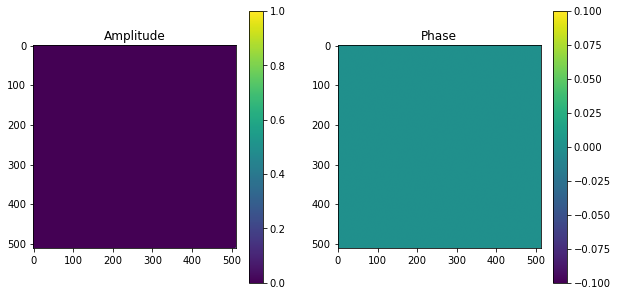

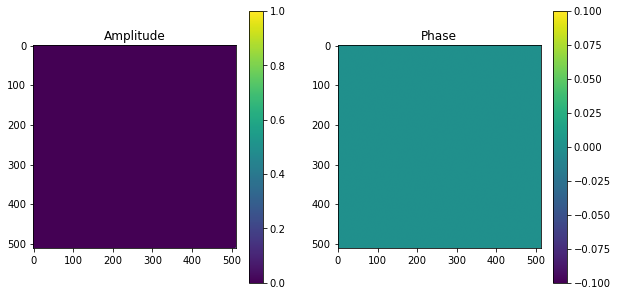

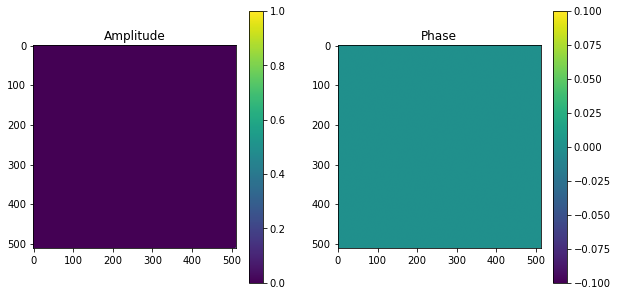

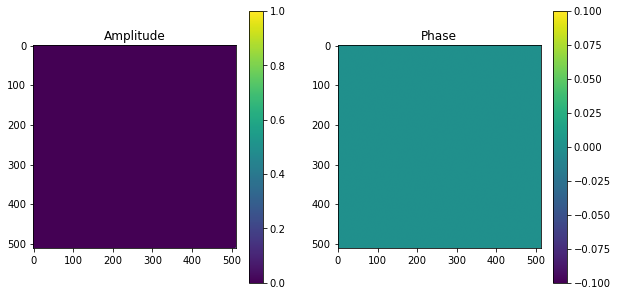

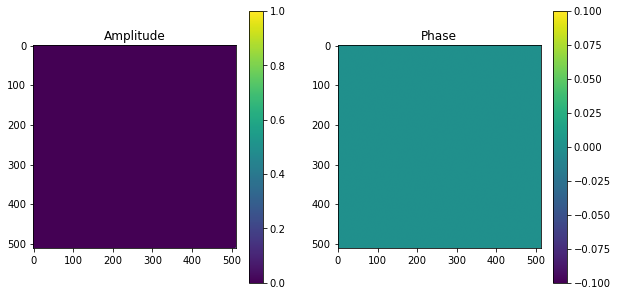

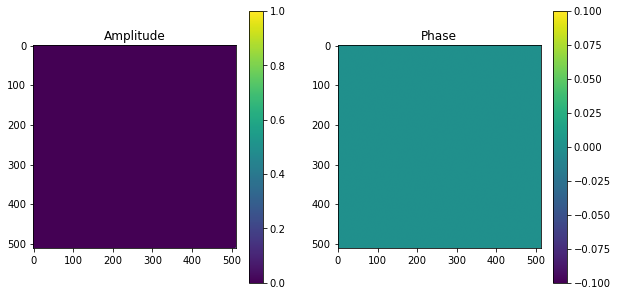

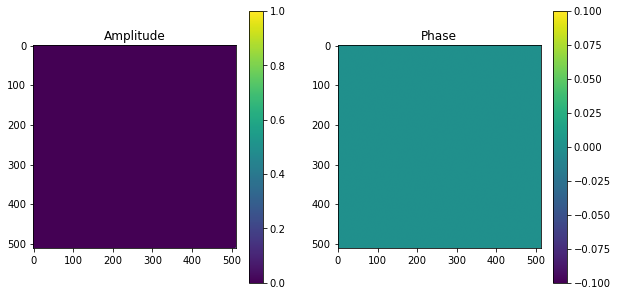

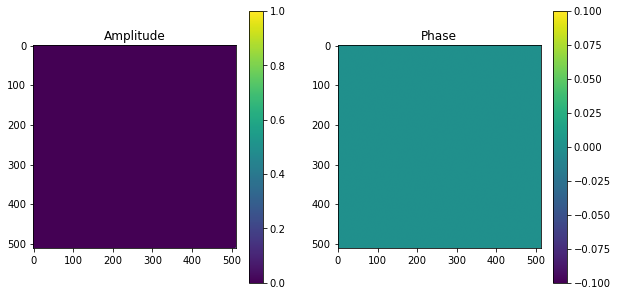

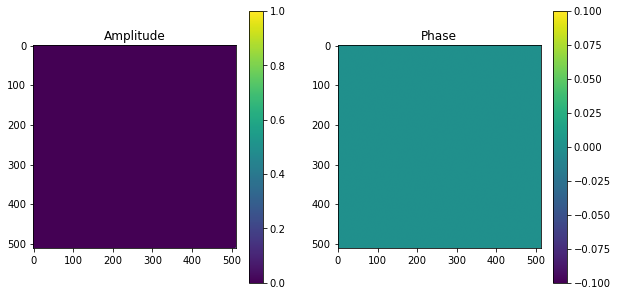

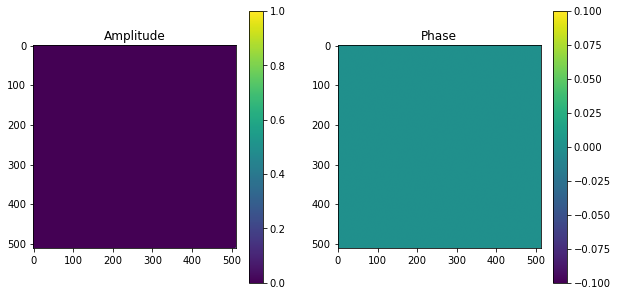

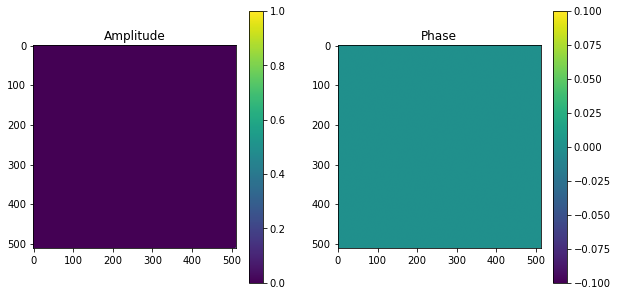

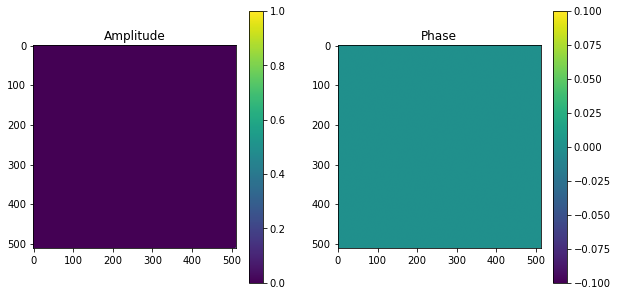

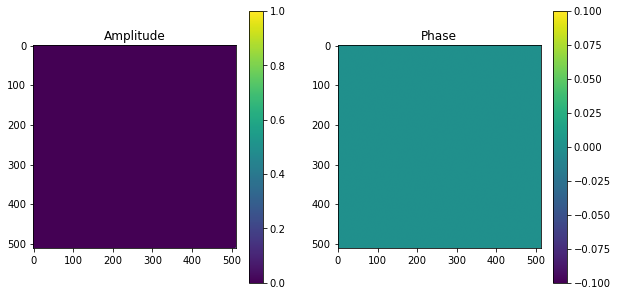

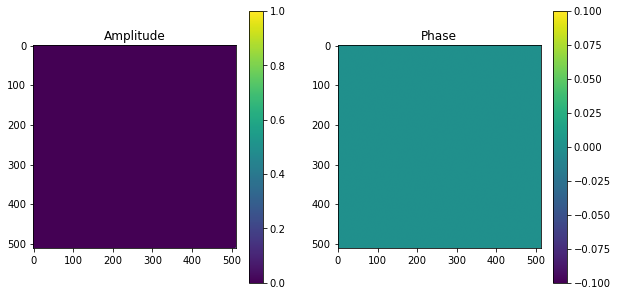

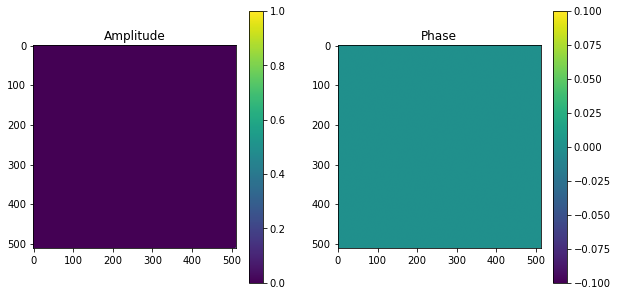

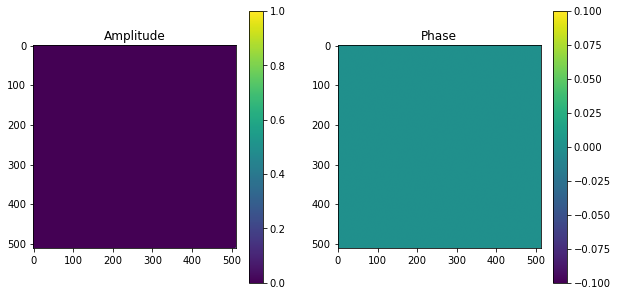

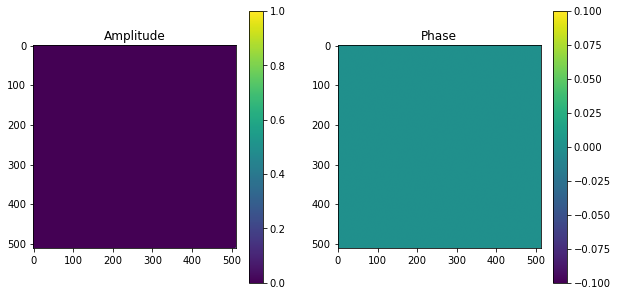

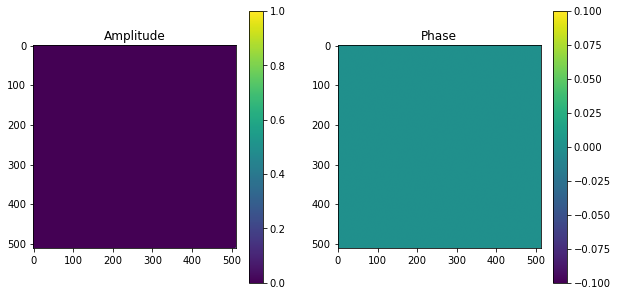

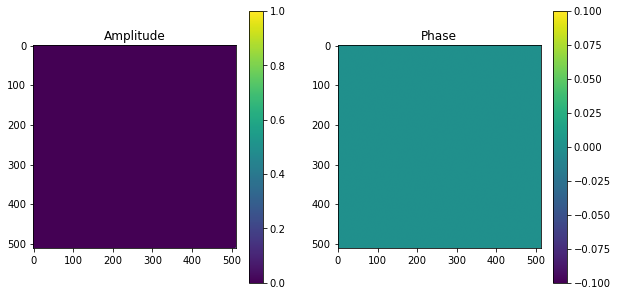

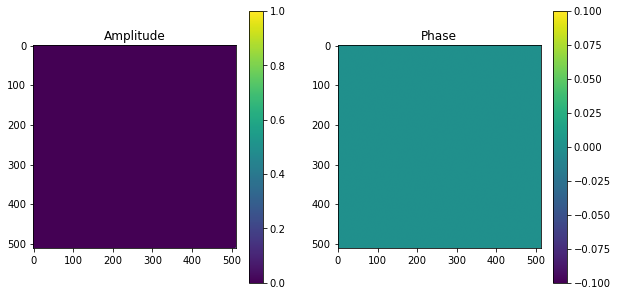

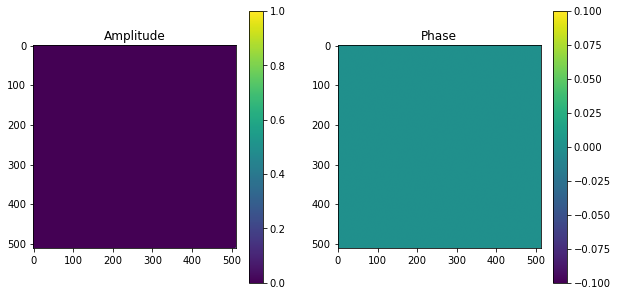

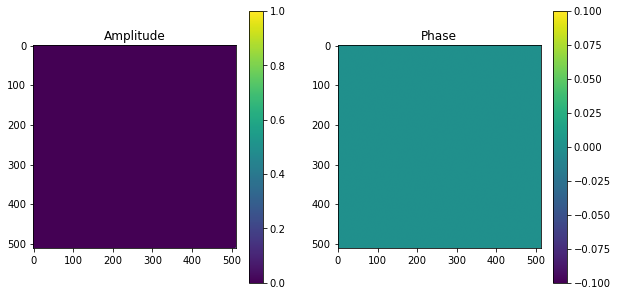

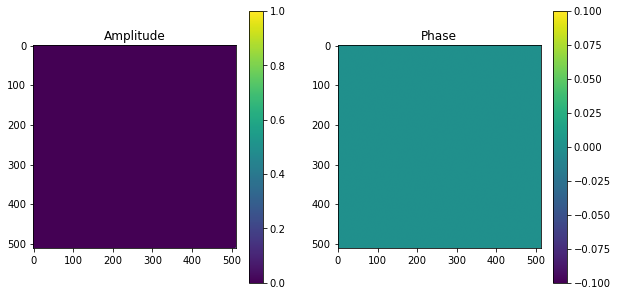

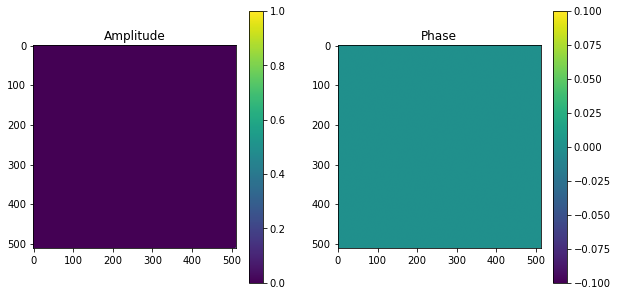

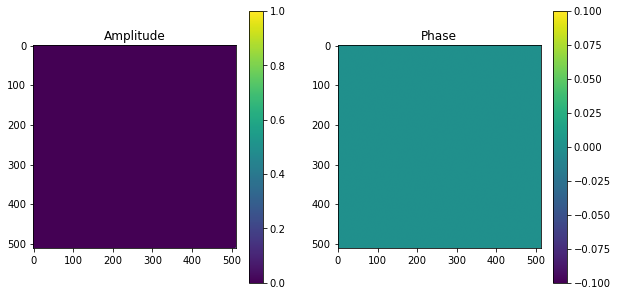

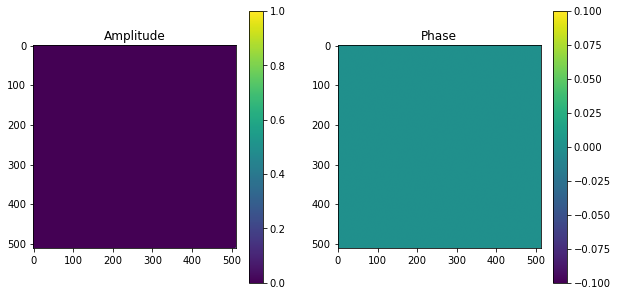

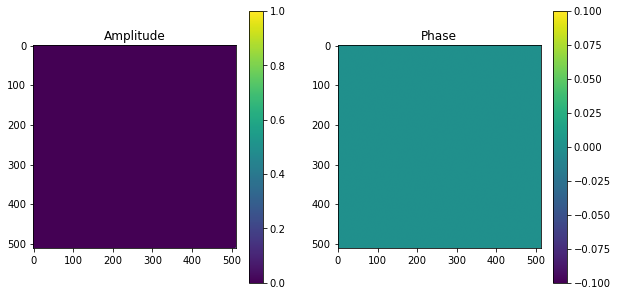

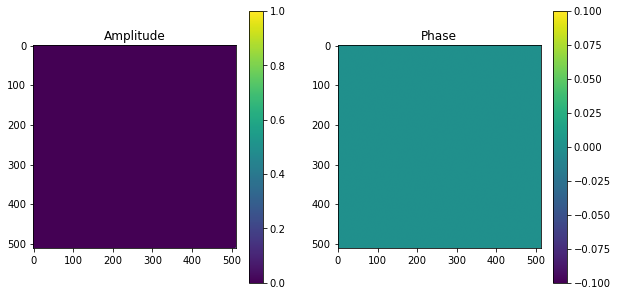

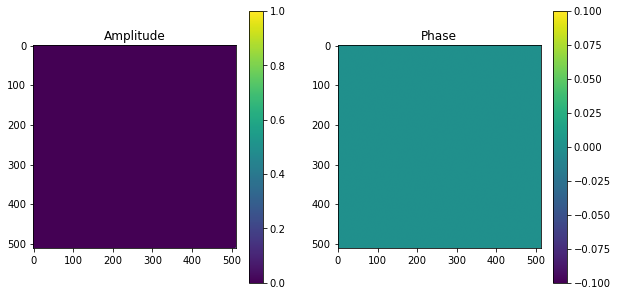

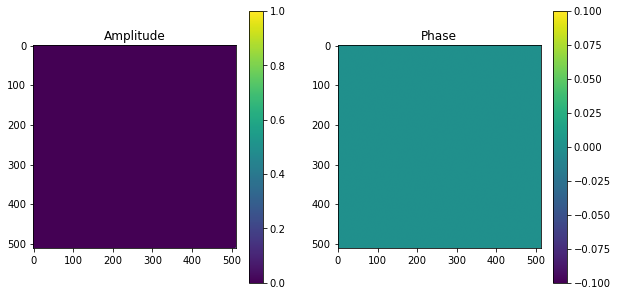

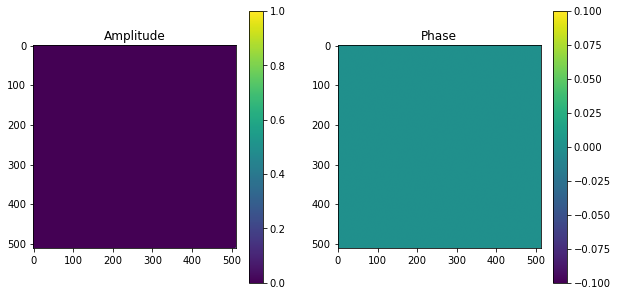

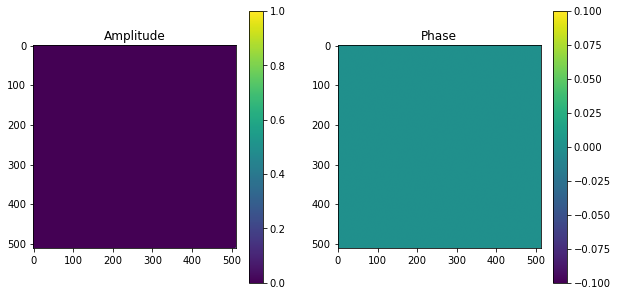

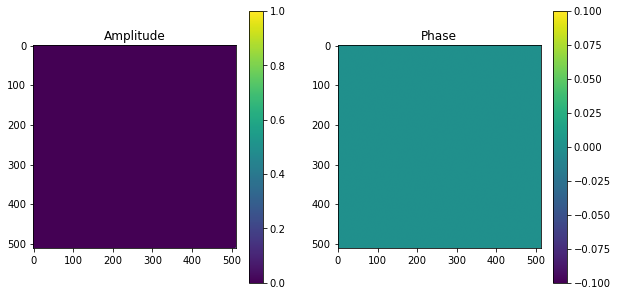

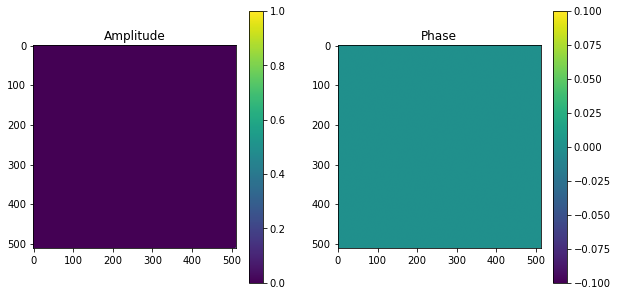

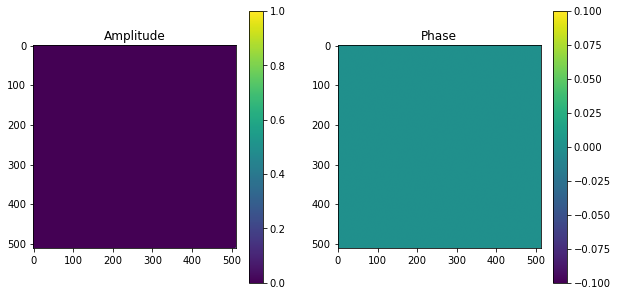

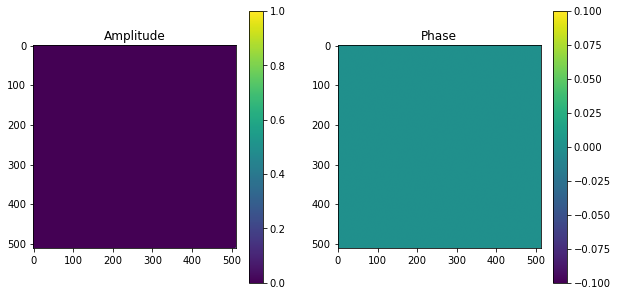

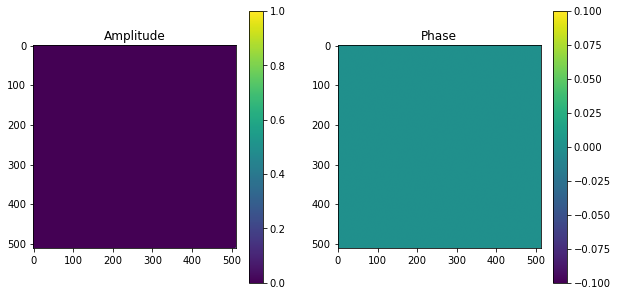

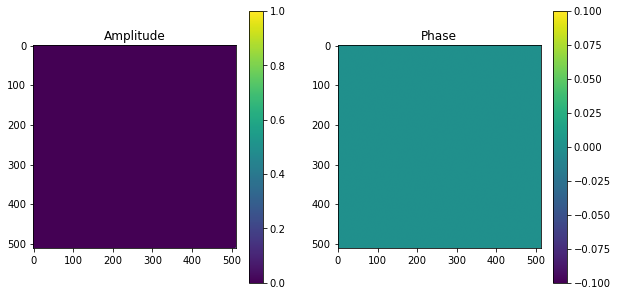

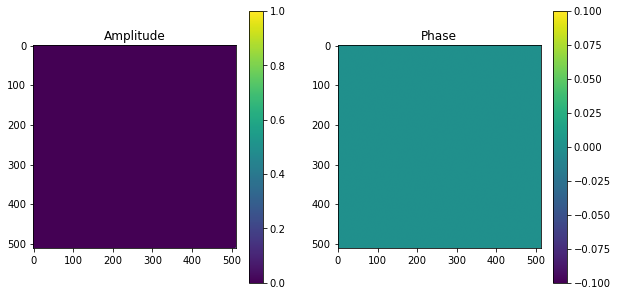

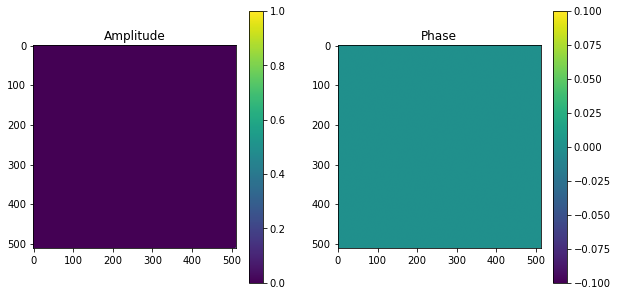

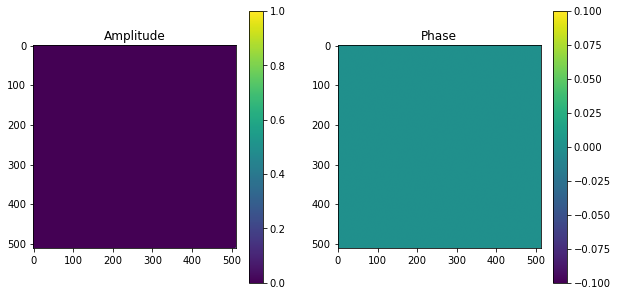

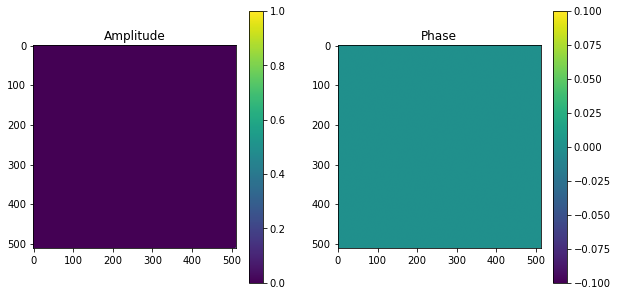

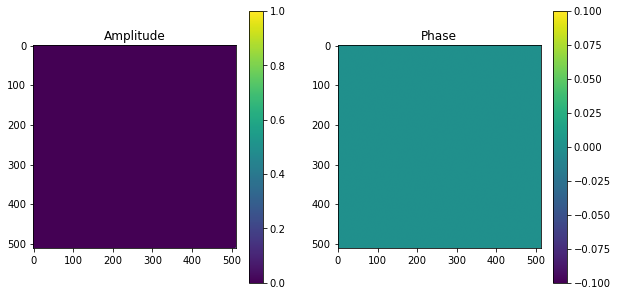

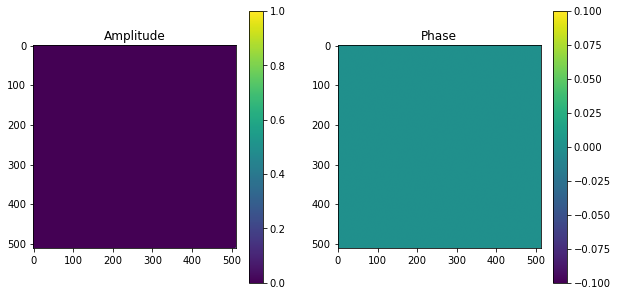

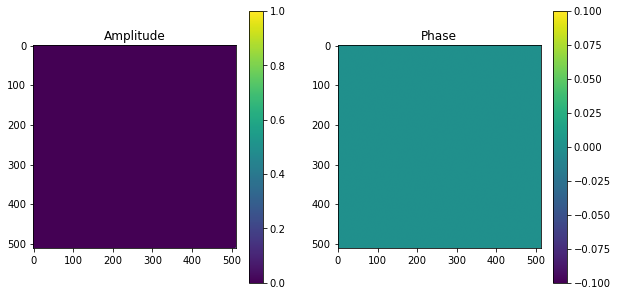

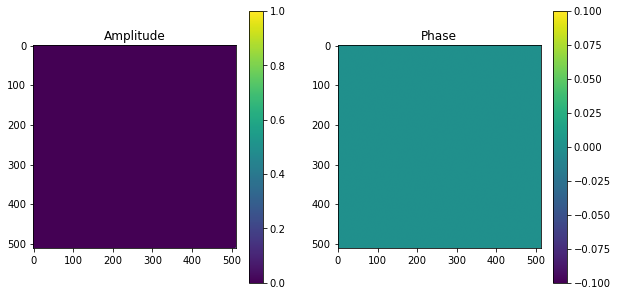

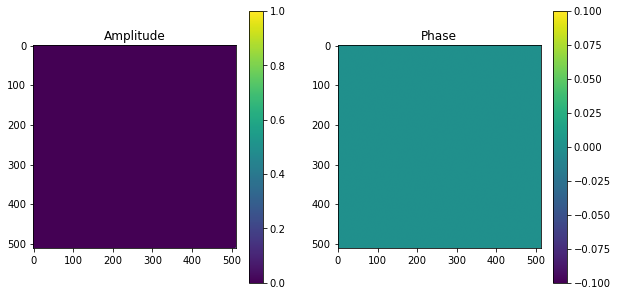

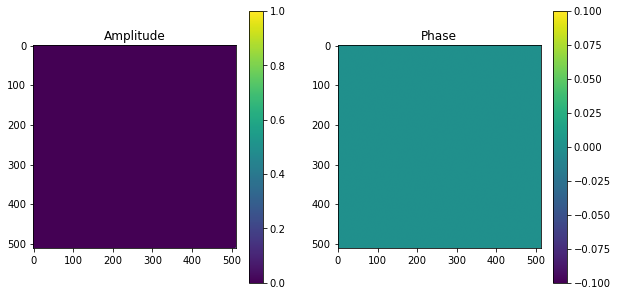

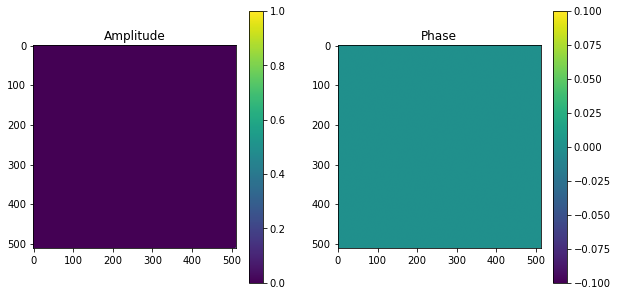

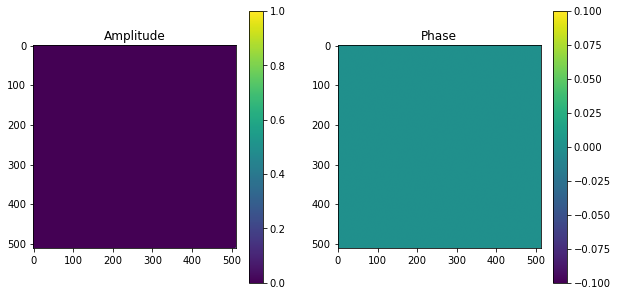

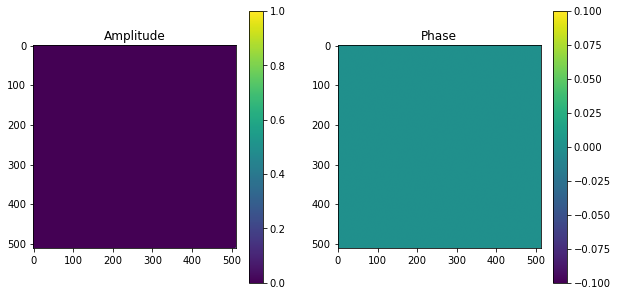

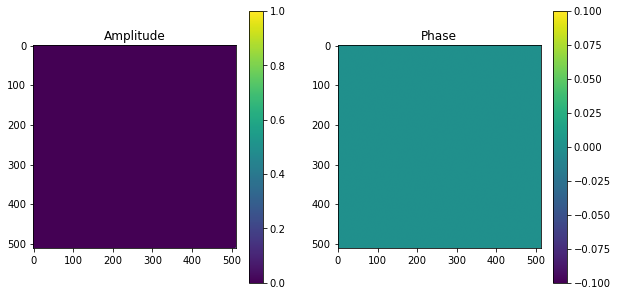

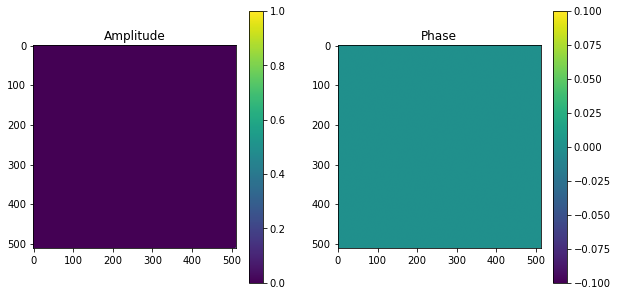

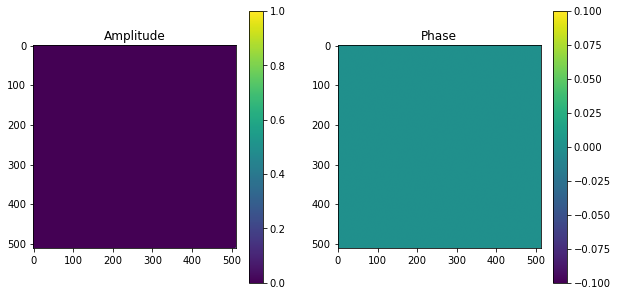

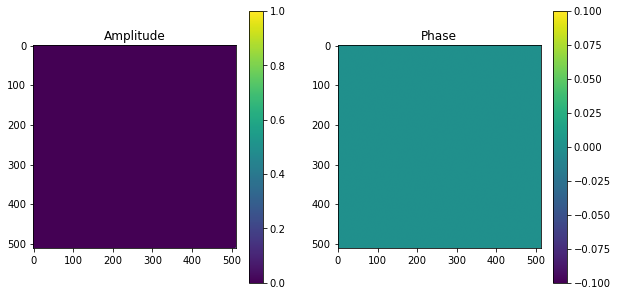

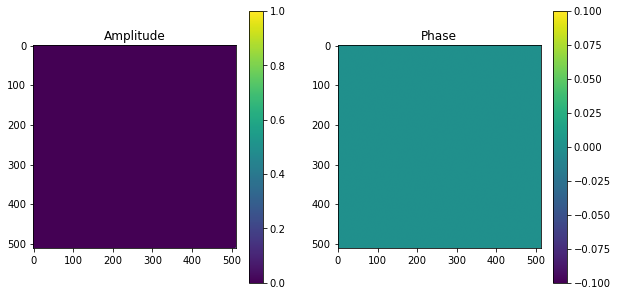

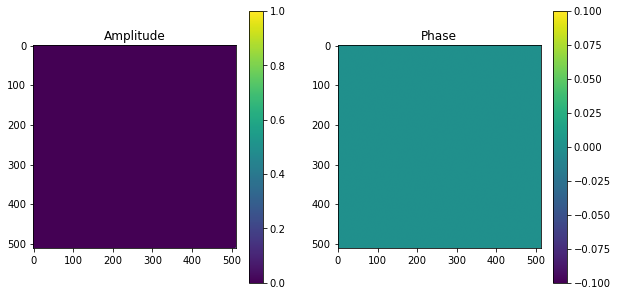

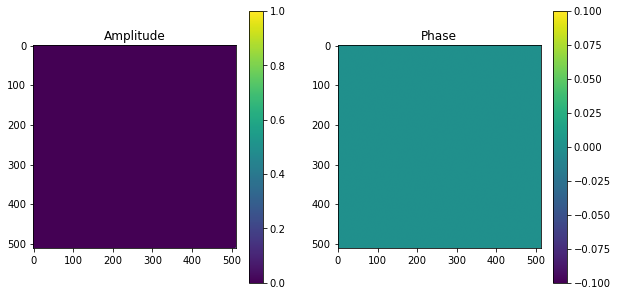

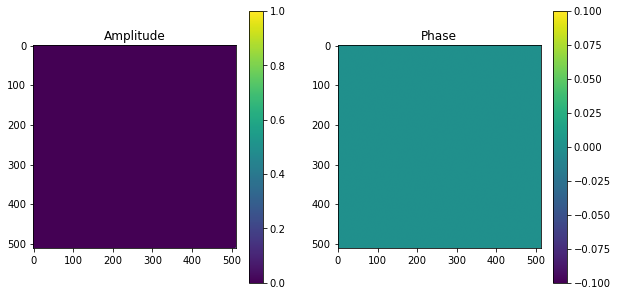

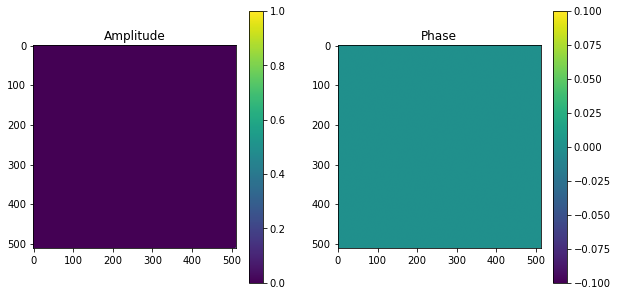

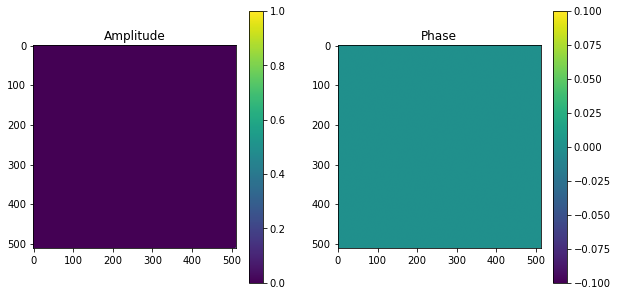

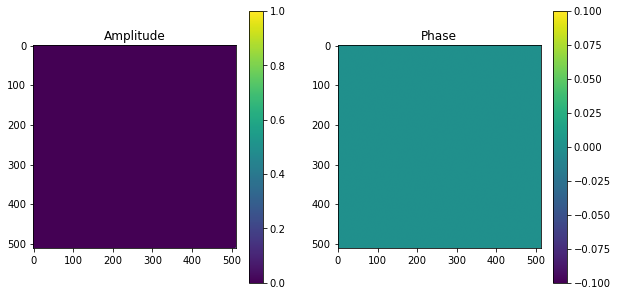

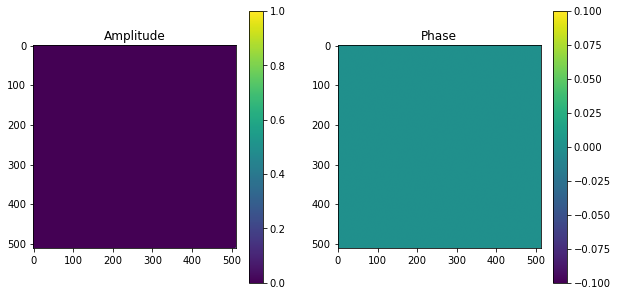

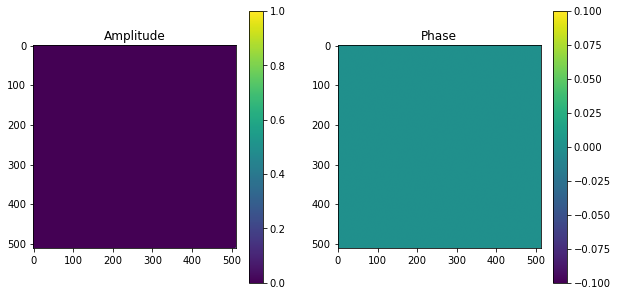

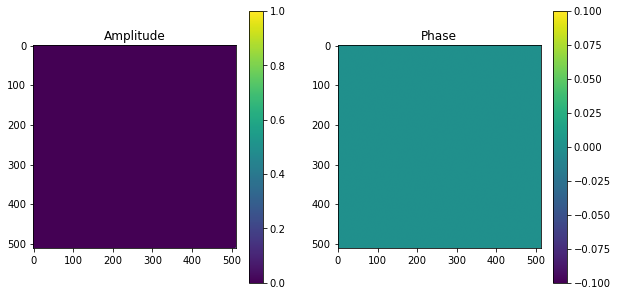

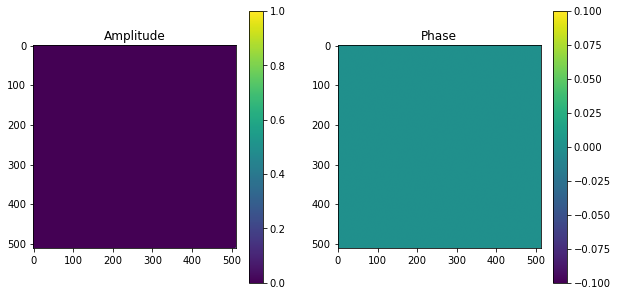

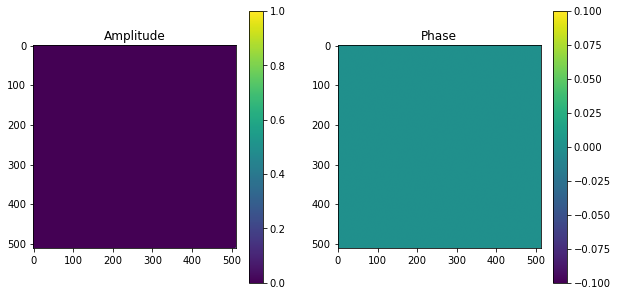

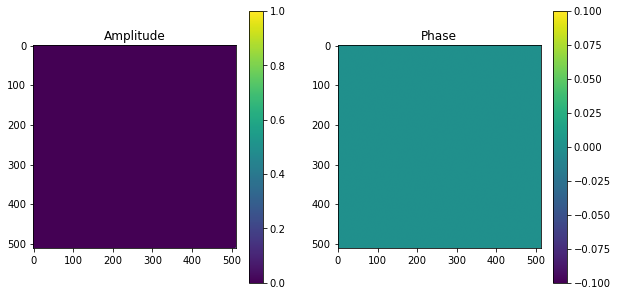

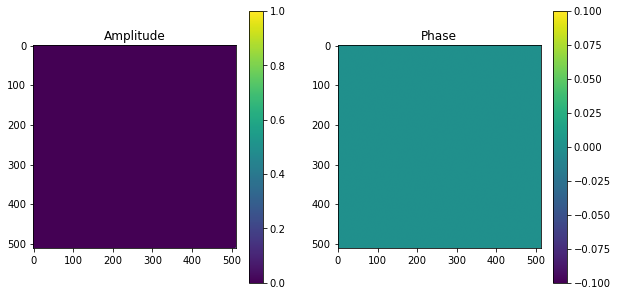

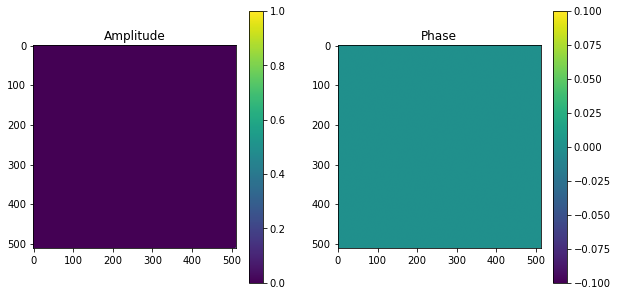

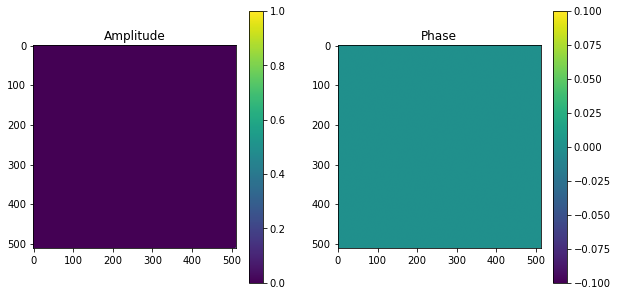

In [4]:
import matplotlib.pyplot as plt

for abc in range(nrays*nrays):
    
    if abc == 0:
        beam = beamlist[:,:,abc]
    else:
        beam += beamlist[:,:,abc]

    plt.figure(figsize=[10,5])
    plt.subplot(121)
    plt.title('Amplitude')
    plt.imshow(np.abs(beam*np.conj(beam)))
    plt.colorbar()

    plt.subplot(122)
    plt.title('Phase')
    plt.imshow(np.angle(beam))
    plt.colorbar()

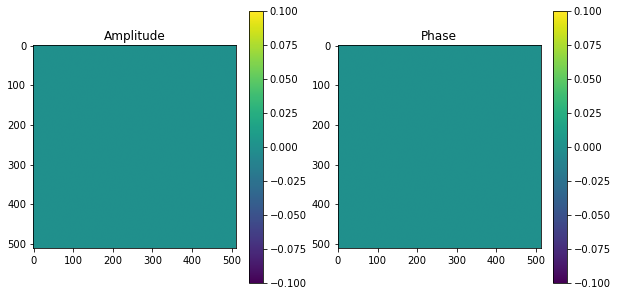

In [10]:
beamfinal = np.sum(beamlist,axis=2)
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('Amplitude')
plt.imshow(np.abs(beamfinal*np.conj(beamfinal)))
plt.colorbar()

plt.subplot(122)
plt.title('Phase')
plt.imshow(np.angle(beamfinal))
plt.colorbar()

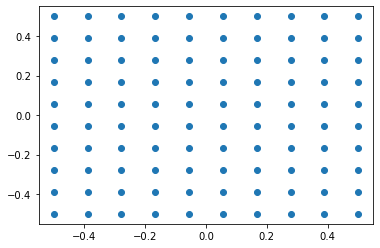

In [6]:
plt.scatter(xlis,ylis)

In [7]:
sys

array([[1.e-20, 0.e+00, 1.e+01, 0.e+00],
       [0.e+00, 1.e-20, 0.e+00, 1.e+01],
       [0.e+00, 0.e+00, 1.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 1.e+00]])